# Imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import optuna

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from scipy.optimize import minimize
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split


import warnings
warnings.filterwarnings("ignore", category=UserWarning, message="'verbose' argument is deprecated.*")

### Path management

In [2]:
base: str
if os.getcwd() == "/kaggle/working":
    base = "/kaggle"
else:
    base = os.path.join(os.getcwd())

def get_full_dir(sub_dir: str) -> str:
    return os.path.join(base, sub_dir)

# EDA

In [3]:
df_sample_submission: pd.DataFrame = pd.read_csv(get_full_dir('input/playground-series-s3e17/sample_submission.csv'))
df_train: pd.DataFrame = pd.read_csv(get_full_dir('input/playground-series-s3e17/train.csv'), index_col='id')
df_test: pd.DataFrame = pd.read_csv(get_full_dir('input/playground-series-s3e17/test.csv'), index_col='id')
df_og: pd.DataFrame = pd.read_csv(get_full_dir('input/machine-failure-predictions/machine failure.csv'), index_col='UDI')

In [4]:
df_train.isna().sum()

Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

In [5]:
df_test.isna().sum()

Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

In [6]:
df_og.isna().sum()

Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

No missing value, doesn't hurt to check.

In [7]:
df_sample_submission.head()

,id,Machine failure
0,136429,0.5
1,136430,0.5
2,136431,0.5
3,136432,0.5
4,136433,0.5


We are simple predicting the probably of whether a give machine will fail.

In [8]:
df_train.head()

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
id,,,,,,,,,,,,,
0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


In [9]:
df_test.head()

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
id,,,,,,,,,,,,
136429,L50896,L,302.3,311.5,1499,38.0,60,0,0,0,0,0
136430,L53866,L,301.7,311.0,1713,28.8,17,0,0,0,0,0
136431,L50498,L,301.3,310.4,1525,37.7,96,0,0,0,0,0
136432,M21232,M,300.1,309.6,1479,47.6,5,0,0,0,0,0
136433,M19751,M,303.4,312.3,1515,41.3,114,0,0,0,0,0


In [10]:
df_og.head()

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
UDI,,,,,,,,,,,,,
1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [11]:
df_train.describe()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000
mean,299.862776,309.941070,1520.331110,40.348643,104.408901,0.015744,0.001554,0.005160,0.002397,0.003958,0.002258
std,1.862247,1.385173,138.736632,8.502229,63.965040,0.124486,0.039389,0.071649,0.048899,0.062789,0.047461
min,295.300000,305.800000,1181.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,298.300000,308.700000,1432.000000,34.600000,48.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,300.000000,310.000000,1493.000000,40.400000,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,301.200000,310.900000,1580.000000,46.100000,159.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,304.400000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
df_test.describe()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
count,90954.000000,90954.000000,90954.000000,90954.000000,90954.000000,90954.000000,90954.000000,90954.000000,90954.00000,90954.000000
mean,299.859493,309.939375,1520.528179,40.335191,104.293962,0.001473,0.005343,0.002353,0.00387,0.002309
std,1.857562,1.385296,139.970419,8.504683,63.871092,0.038355,0.072903,0.048449,0.06209,0.047995
min,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,298.300000,308.700000,1432.000000,34.600000,48.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,300.000000,310.000000,1493.000000,40.500000,106.000000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,301.200000,310.900000,1579.000000,46.200000,158.000000,0.000000,0.000000,0.000000,0.00000,0.000000
max,304.400000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.00000,1.000000


In [13]:
df_og.describe()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,0.004600,0.011500,0.009500,0.009800,0.00190
std,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.067671,0.106625,0.097009,0.098514,0.04355
min,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


In [14]:
skip_test_palette = [sns.color_palette("tab10")[0], sns.color_palette("tab10")[2]]

In [15]:
def graph_cat_dis(data: list[(pd.DataFrame, str, str)], x_label: str=None, y_label: str=None, title: str=None, ax: object=None, size: tuple[int, int]=(10, 5), palette=sns.color_palette("tab10")) -> None:
    """
    Graphs distribution of a categorical feature, has an option to pass more than one dataframe and compare distributions between the different dataset.

    :param data: (dataframe, column name to graph, dataset name)
    :param x_label: Label for the x-axis (optional)
    :param y_label: Label for the y-axis (optional)
    :param title: Title for the graph (optional)
    :param ax: Axes for the graph, (optional) if not provided one will be automatically created
    :param size: Size of the graph, (optional) use when ax is not provided#
    :param palette: Color palette to use
    :return: void
    """
    
    # Create axes is not give
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=size)
    
    # Gater data
    df_tmp = pd.DataFrame({})
    for df, column, label in data:
        df_tmp_local = pd.DataFrame(df[column].value_counts() * 100 / df[column].count())
        df_tmp_local['dataset'] = label
        df_tmp = pd.concat([df_tmp, df_tmp_local], axis=0)

    # Plot barplots
    df_tmp['x'] = df_tmp.index
    df_tmp = df_tmp.rename(columns={data[0][1]: 'y', 'dataset': 'Data Set'})
    sns.barplot(data=df_tmp, y='y', x="x", hue="Data Set", orient='v', ax=ax, palette=palette)

    # Annotate
    for p in ax.patches:
        ax.annotate(
            format(p.get_height(), '.0f') + '%',
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha = 'center', va = 'center',
            xytext = (0, 5),
            textcoords = 'offset points')

    ax.set_xlabel(x_label, fontsize=14)
    ax.set_ylabel(y_label, fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend()

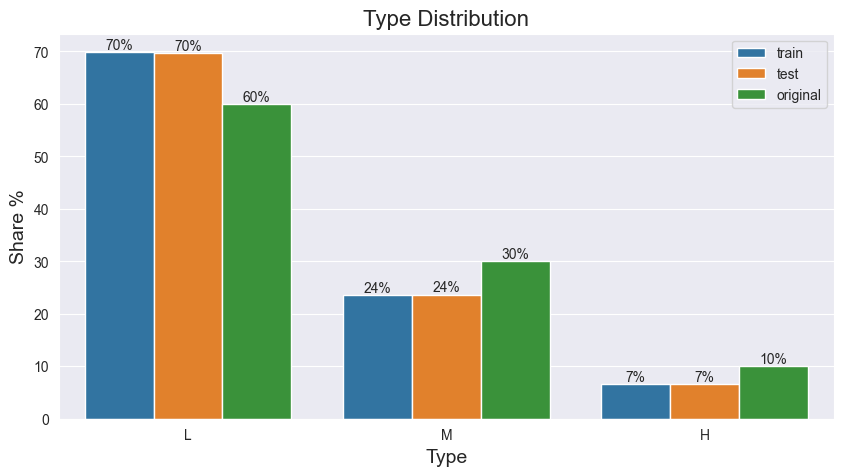

In [16]:
graph_cat_dis([(df_train, 'Type', 'train'), (df_test, 'Type', 'test'), (df_og, 'Type', 'original')], x_label='Type', y_label='Share %', title='Type Distribution')
plt.show()

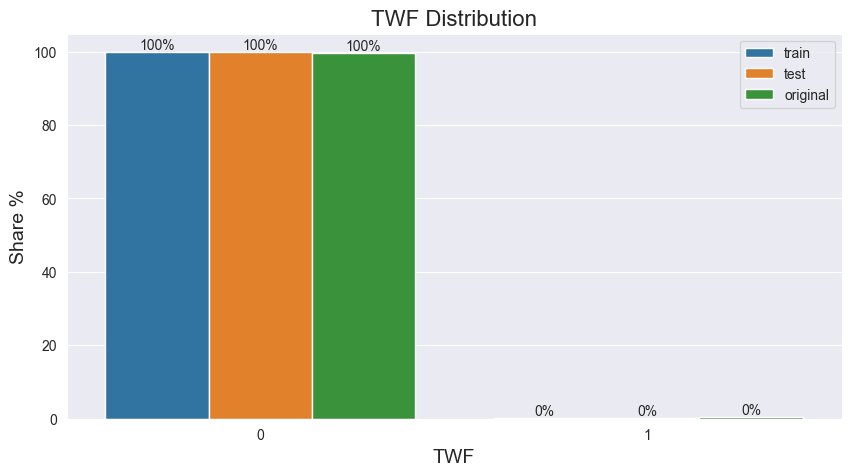

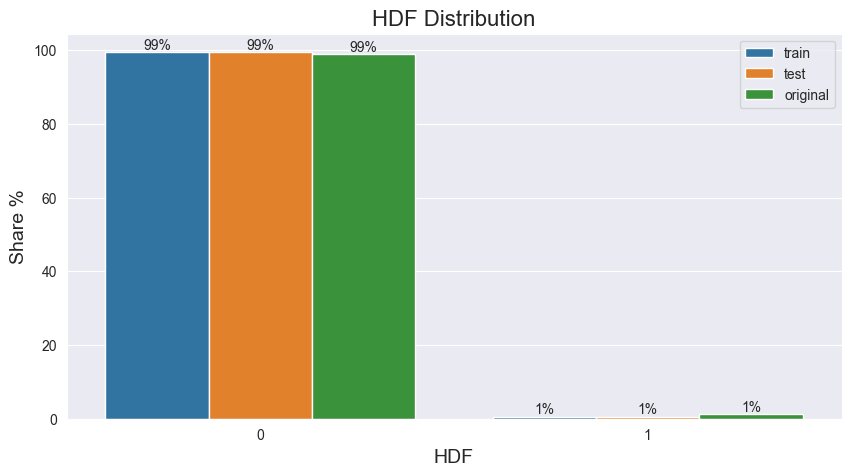

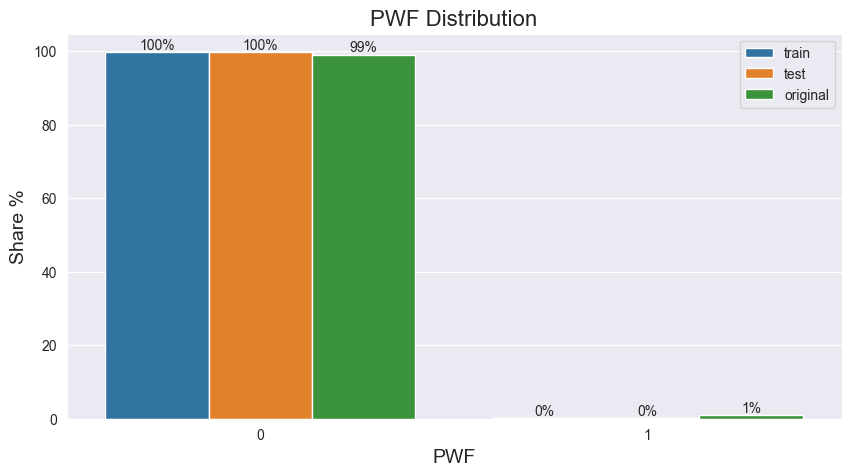

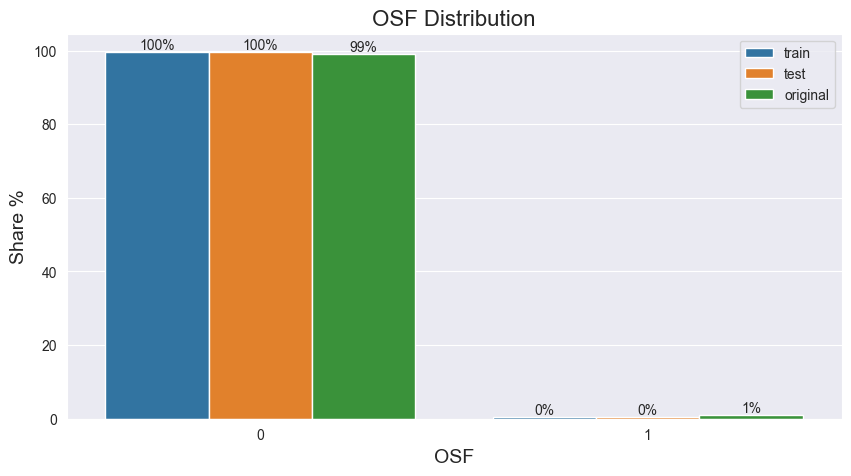

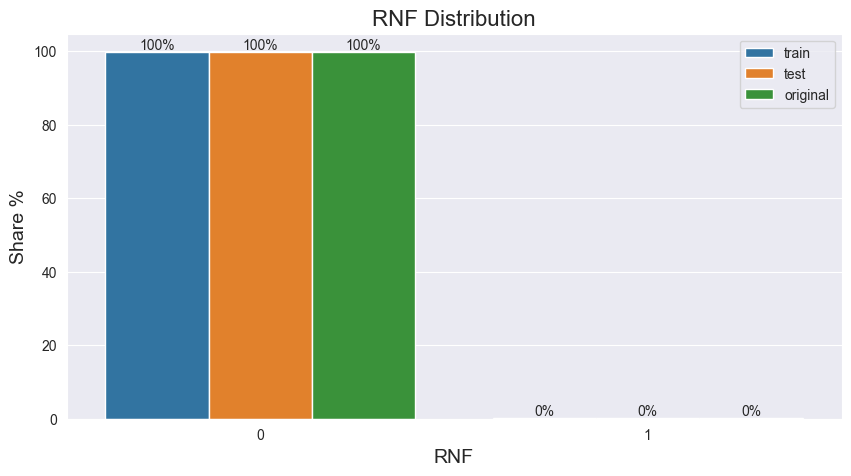

In [17]:
for f in ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']:
    graph_cat_dis([(df_train, f, 'train'), (df_test, f, 'test'), (df_og, f, 'original')], x_label=f, y_label='Share %', title=f'{f} Distribution')
    plt.show()

We can simply drop this feature all this features, its almost always 0, so it does not contain any valuable information for our model.

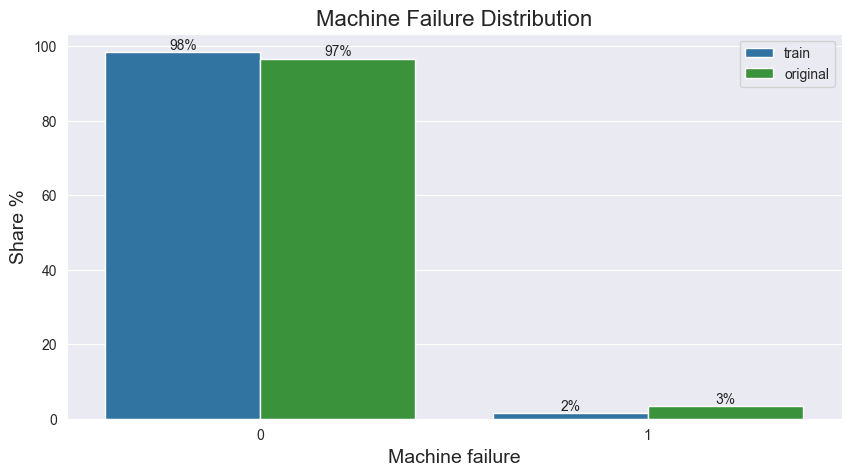

In [18]:
graph_cat_dis([(df_train, 'Machine failure', 'train'), (df_og, 'Machine failure', 'original')], x_label='Machine failure', y_label='Share %', title='Machine Failure Distribution', palette=skip_test_palette)
plt.show()

There is a large class imbalance, this will likely result in poor model preform if not addressed. We can resolve this problem during training by adjusting class weight.

In [19]:
def graph_kdeplot(data: list[(pd.DataFrame, str, str)], x_label: str=None, y_label: str=None, title: str=None, ax: object=None, size: tuple[int, int]=(5, 5), palette=sns.color_palette("tab10")) -> None:
    """
    TODO

    :param data: (dataframe, column name to graph, dataset name)
    :param x_label: Label for the x-axis (optional)
    :param y_label: Label for the y-axis (optional)
    :param title: Title for the graph (optional)
    :param ax: Axes for the graph, (optional) if not provided one will be automatically created
    :param size: Size of the graph, (optional) use when ax is not provided
    :param palette: Color palette to use
    :return: void
    """

    # Create axes is not give
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=size)

    # Plot kdeplot
    for e, cd in enumerate(data):
        df, column, label = cd
        sns.kdeplot(df[column], label=label, ax=ax, fill=False, color=palette[e])

    # Annotate
    ax.set_xlabel(x_label, fontsize=14)
    ax.set_ylabel(y_label, fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend()

def graph_histplot(data: list[(pd.DataFrame, str, str)], x_label: str=None, y_label: str=None, title: str=None, ax: object=None, size: tuple[int, int]=(5, 5), palette=sns.color_palette("tab10")) -> None:
    """
    TODO

    :param data: (dataframe, column name to graph, dataset name)
    :param x_label: Label for the x-axis (optional)
    :param y_label: Label for the y-axis (optional)
    :param title: Title for the graph (optional)
    :param ax: Axes for the graph, (optional) if not provided one will be automatically created
    :param size: Size of the graph, (optional) use when ax is not provided
    :param palette: Color palette to use
    :return: void
    """

    # Create axes is not give
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=size)

    # Plot histplot
    for e, cd in enumerate(data):
        df, column, label = cd
        sns.histplot(df[column], label=label, ax=ax, stat="density", bins=50, color=palette[e])

    # Annotate
    ax.set_xlabel(x_label, fontsize=14)
    ax.set_ylabel(y_label, fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend()

def graph_boxplot(data: list[(pd.DataFrame, str, str)], x_label: str=None, y_label: str=None, title: str=None, ax: object=None, size: tuple[int, int]=(5, 5), palette=sns.color_palette("tab10")) -> None:
    """
    TODO

    :param data: (dataframe, column name to graph, dataset name)
    :param x_label: Label for the x-axis (optional)
    :param y_label: Label for the y-axis (optional)
    :param title: Title for the graph (optional)
    :param ax: Axes for the graph, (optional) if not provided one will be automatically created
    :param size: Size of the graph, (optional) use when ax is not provided
    :param palette: Color palette to use
    :return: void
    """

    # Create axes is not give
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=size)

    # Gater data
    tmp_data_dict = {}
    for df, column, label in data:
        tmp_data_dict[label] = df[column]
    df_tmp = pd.DataFrame(tmp_data_dict)

    # Plot boxplot
    sns.boxplot(data=df_tmp, ax=ax, palette=palette)

    # Annotate
    ax.set_xlabel(x_label, fontsize=14)
    ax.set_ylabel(y_label, fontsize=14)
    ax.set_title(title, fontsize=16)

def graph_corr(data: list[(pd.DataFrame, str, str)], vs: str, x_label: str=None, y_label: str=None, title: str=None, ax: object=None, size: tuple[int, int]=(5, 5), palette=sns.color_palette("tab10")) -> None:
    """
    TODO

    :param data: (dataframe, column name to graph, dataset name)
    :param x_label: Label for the x-axis (optional)
    :param y_label: Label for the y-axis (optional)
    :param title: Title for the graph (optional)
    :param ax: Axes for the graph, (optional) if not provided one will be automatically created
    :param size: Size of the graph, (optional) use when ax is not provided
    :param palette: Color palette to use
    :return: void
    """

    # Create axes is not give
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=size)

    # Plot target correlation
    for e, cd in enumerate(data):
        df, column, label = cd
        sns.scatterplot(x=column, y=vs, label=label, ax=ax, data=df, color=palette[e])

    # Annotate
    ax.set_xlabel(x_label, fontsize=14)
    ax.set_ylabel(y_label, fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend()

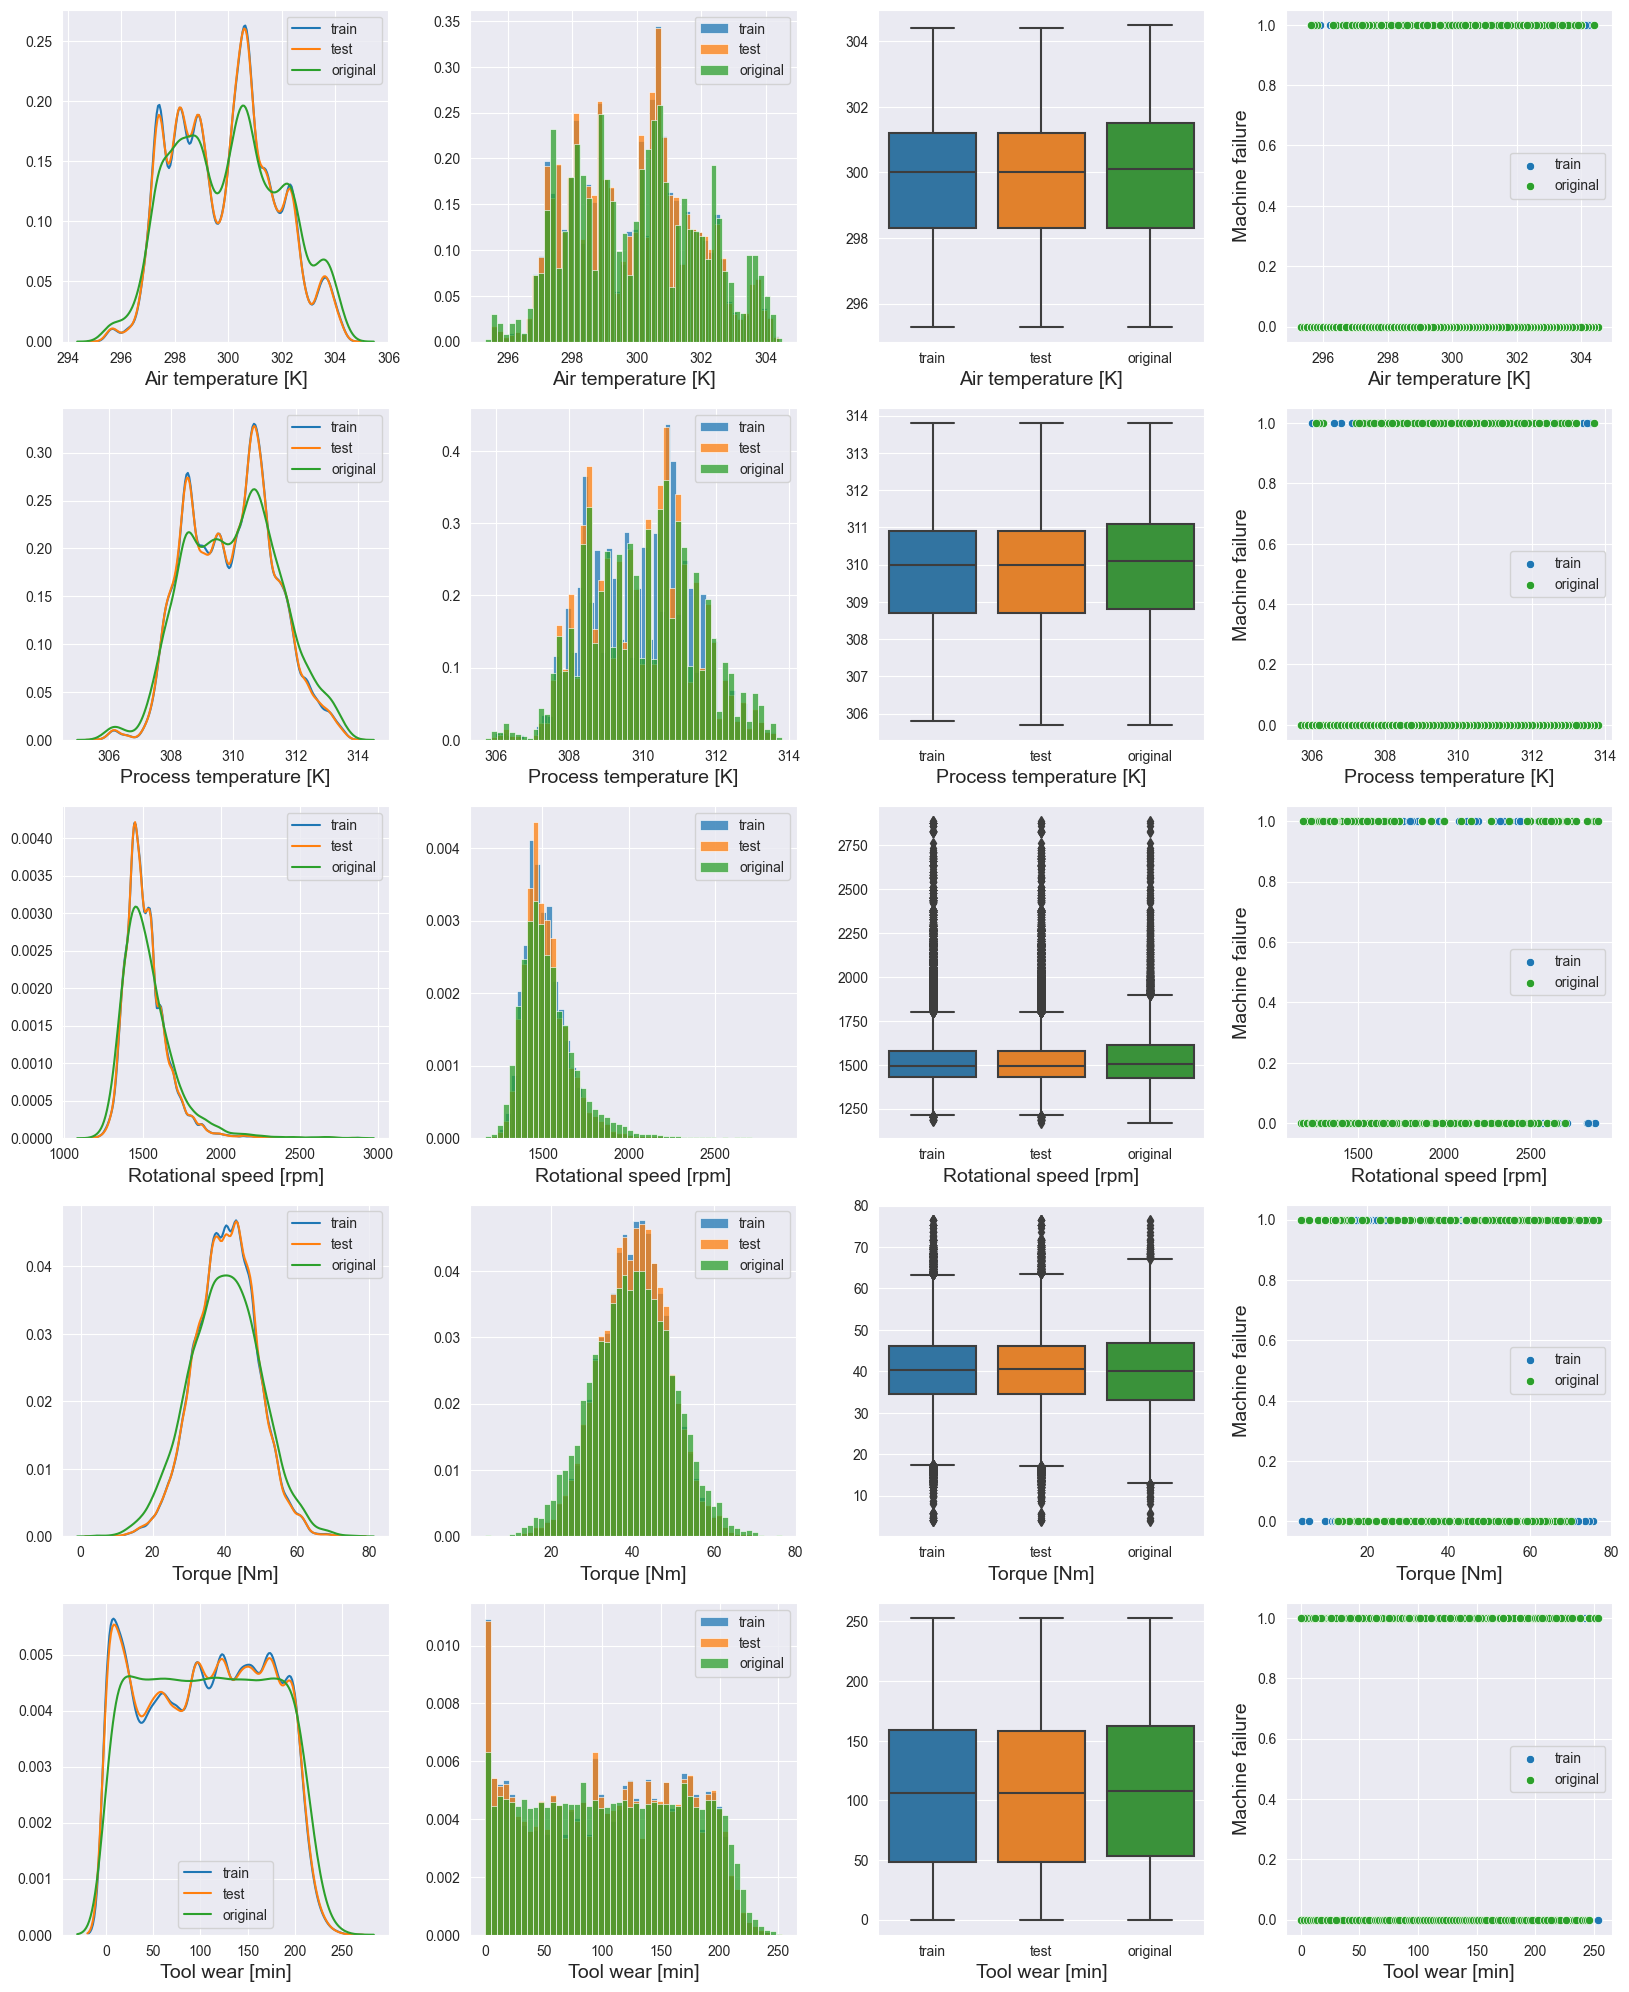

In [20]:
numerical_features_to_graph = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
def graph_numerical_features():
    num_rows = len(numerical_features_to_graph)
    fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(20, 5 * num_rows))
    fig.subplots_adjust(hspace=0.2, wspace=0.25)

    for i, col in enumerate(numerical_features_to_graph):
        graph_kdeplot([(df_train, col, 'train'), (df_test, col, 'test'), (df_og, col, 'original')], ax=axes[i, 0], x_label=col)
        graph_histplot([(df_train, col, 'train'), (df_test, col, 'test'), (df_og, col, 'original')], ax=axes[i, 1], x_label=col)
        graph_boxplot([(df_train, col, 'train'), (df_test, col, 'test'), (df_og, col, 'original')], ax=axes[i, 2], x_label=col)
        graph_corr([(df_train, col, 'train'), (df_og, col, 'original')], 'Machine failure', ax=axes[i, 3], x_label=col, palette=skip_test_palette, y_label='Machine failure')

    plt.show()
graph_numerical_features()

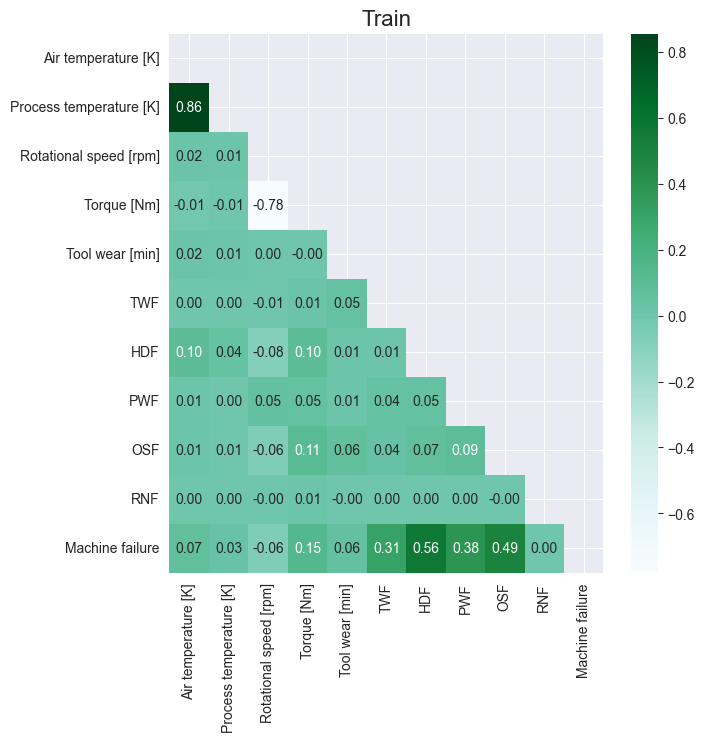

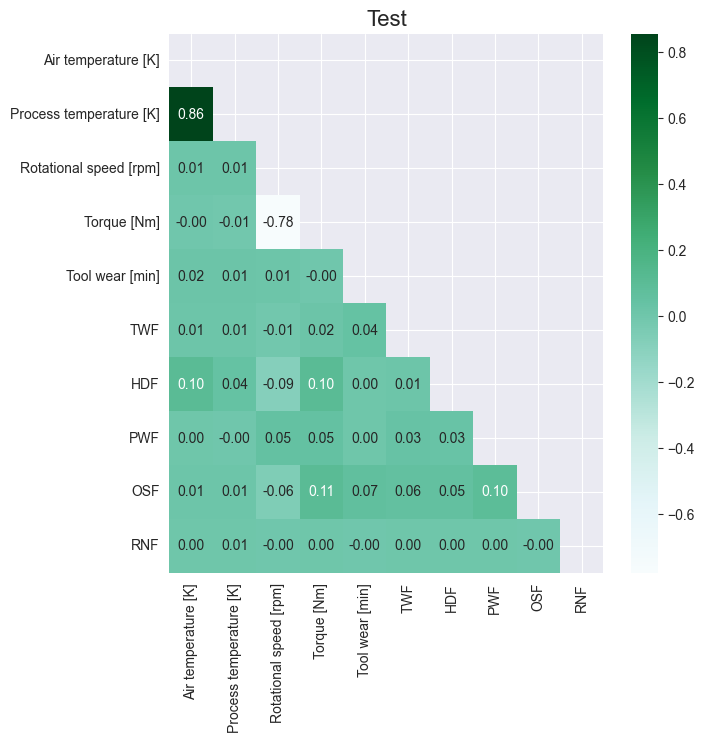

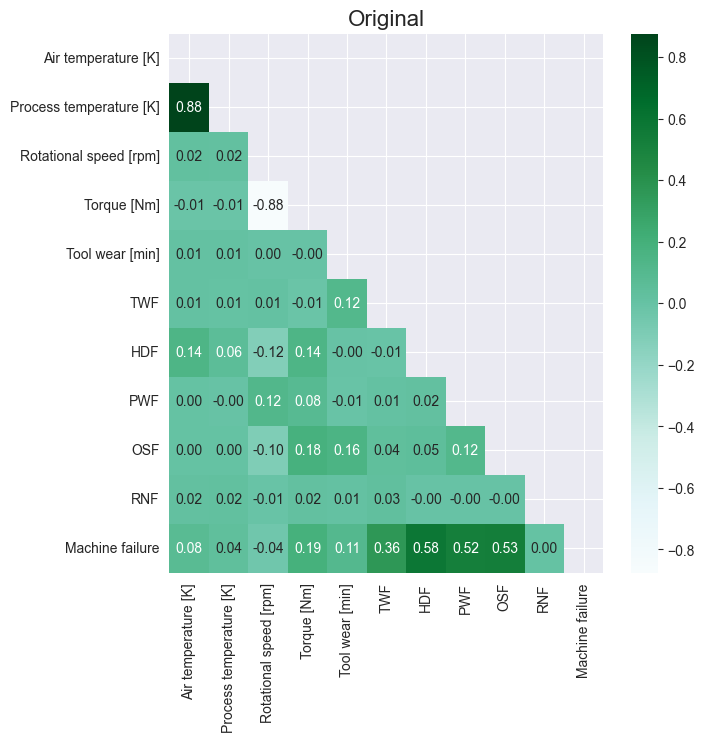

In [21]:
def show_feature_correlation(df: pd.DataFrame, title: str, columns: [str]):
    plt.figure(figsize=(7, 7))
    corr_matrix = df[columns].corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr_matrix, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    sns.heatmap(corr_matrix, cmap='BuGn', annot=True, mask=mask, fmt=".2f")
    plt.title(title, fontsize=16)
    plt.yticks(rotation=360) # I don't know why rotating by 360 as an effect of 90 degree ration, 90-degree rotation had no effect
    plt.show()

show_feature_correlation(df_train, "Train", ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'Machine failure'])
show_feature_correlation(df_test, "Test", ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'])
show_feature_correlation(df_og, "Original", ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'Machine failure'])

# Data Prep

In [22]:
import re

def remove_special_characters(column_name):
    return re.sub(r"[^a-zA-Z0-9_]+", "", column_name)

def remove_special_characters_from_dataframe(df):
    df.columns = [remove_special_characters(col) for col in df.columns]
    return df

In [23]:
df_train: pd.DataFrame = pd.read_csv(get_full_dir('input/playground-series-s3e17/train.csv'), index_col='id')
df_test: pd.DataFrame = pd.read_csv(get_full_dir('input/playground-series-s3e17/test.csv'), index_col='id')
df_og: pd.DataFrame = pd.read_csv(get_full_dir('input/machine-failure-predictions/machine failure.csv'), index_col='UDI')

In [24]:
df_train = remove_special_characters_from_dataframe(df_train)
df_test = remove_special_characters_from_dataframe(df_test)
df_og = remove_special_characters_from_dataframe(df_og)

In [25]:
useless_features = ['ProductID'] #, 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'
df_train.drop(useless_features, axis=1, inplace=True)
df_test.drop(useless_features, axis=1, inplace=True)
df_og.drop(useless_features, axis=1, inplace=True)

In [26]:
numerical_features = ['AirtemperatureK', 'ProcesstemperatureK', 'Rotationalspeedrpm', 'TorqueNm', 'Toolwearmin']
categorical_features = ['Type']
target = 'Machinefailure'

In [27]:
df_train: pd.DataFrame = pd.concat([df_train, df_og])
df_train.reset_index(inplace=True, drop=True)

In [28]:
df_train = pd.get_dummies(df_train, columns=categorical_features)
df_test = pd.get_dummies(df_test, columns=categorical_features)

In [29]:
#df_train, df_holdout = train_test_split(df_train, test_size=0.2, random_state=1)

In [30]:
scaler = StandardScaler()
scaler.fit(df_train[numerical_features])
df_train[numerical_features] = scaler.transform(df_train[numerical_features])
df_test[numerical_features] = scaler.transform(df_test[numerical_features])
#df_holdout[numerical_features] = scaler.transform(df_holdout[numerical_features])

# Assembly

## Hypermarket search

In [31]:
def objective(trial):
    # Define the hyperparameter search space
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'n_estimators': 1000,
        'max_depth': trial.suggest_int('max_depth', 4, 32),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'subsample': 0.6,
        'n_jobs': -1,
        'verbosity': 0
    }

    # Split the data into training and validation sets
    X = df_train.drop(target, axis=1)
    y = df_train[target]
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=41)

    # Train the XGBoost classifier
    model = xgb.XGBClassifier(**params, eval_sets=[X_val, y_val])
    model.fit(X_train, y_train)

    # Predict probabilities on the validation set and calculate ROC AUC
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred_proba)

    return 1 - auc  # As we are minimizing the objective

# Create the Optuna study
study_xgb = optuna.create_study(direction='minimize')

# Start the hyperparameter search
study_xgb.optimize(objective, n_trials=15)

# Print the best parameters and the best AUC
best_params = study_xgb.best_params
best_auc = 1 - study_xgb.best_value
print(f"Best Parameters: {study_xgb.best_value}")
print(f"Best AUC: {best_auc}")

xgb_param = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'n_estimators': 10000,
    'max_depth': study_xgb.best_params['max_depth'],
    'reg_alpha': study_xgb.best_params['reg_alpha'],
    'reg_lambda': study_xgb.best_params['reg_lambda'],
    'subsample': 0.6,
    'n_jobs': -1
}

[I 2023-06-19 22:03:15,800] A new study created in memory with name: no-name-0b62d493-be56-4158-b582-34c9d0a7c3cd
[I 2023-06-19 22:03:42,007] Trial 0 finished with value: 0.03547237784272761 and parameters: {'max_depth': 4, 'reg_alpha': 4.956080937274879, 'reg_lambda': 2.5860390182730244}. Best is trial 0 with value: 0.03547237784272761.
[I 2023-06-19 22:04:20,039] Trial 1 finished with value: 0.033626504590081874 and parameters: {'max_depth': 14, 'reg_alpha': 4.169082823155888, 'reg_lambda': 4.807294506969876}. Best is trial 1 with value: 0.033626504590081874.
[I 2023-06-19 22:04:57,477] Trial 2 finished with value: 0.03521825663767597 and parameters: {'max_depth': 9, 'reg_alpha': 2.9557753526789843, 'reg_lambda': 5.7133363713882455}. Best is trial 1 with value: 0.033626504590081874.
[I 2023-06-19 22:05:39,080] Trial 3 finished with value: 0.03298239539707937 and parameters: {'max_depth': 18, 'reg_alpha': 1.6350500946573243, 'reg_lambda': 8.379081787540567}. Best is trial 3 with value

Best Parameters: 0.031010649677354896
Best AUC: 0.9689893503226451


In [32]:
def objective(trial):
    # Define the hyperparameter search space
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'n_estimators': 1000,
        'max_depth': trial.suggest_int('max_depth', 5, 32),
        'num_leaves': trial.suggest_int('num_leaves', 50, 250),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.6),
        'min_child_samples': trial.suggest_int('min_child_samples', 64, 512),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'subsample': 0.6,
        'n_jobs': -1,
    }

    # Split the data into training and validation sets
    X = df_train.drop(target, axis=1)
    y = df_train[target]
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=41)

    # Train the LGBM classifier
    model = lgb.LGBMClassifier(**params)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    # Predict probabilities on the validation set and calculate ROC AUC
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred_proba)

    return 1 - auc  # As we are minimizing the objective

# Create the Optuna study
study_lgbm = optuna.create_study(direction='minimize')

# Start the hyperparameter search
study_lgbm.optimize(objective, n_trials=50)

# Print the best parameters and the best AUC
best_params = study_lgbm.best_params
best_auc = 1 - study_lgbm.best_value
print(f"Best Parameters: {best_params}")
print(f"Best AUC: {best_auc}")

lgbm_params = {
    'objective': 'binary',
    'metric': 'auc',
    'n_estimators': 10000,
    'max_depth': study_lgbm.best_params['max_depth'],
    'num_leaves': study_lgbm.best_params['num_leaves'],
    'colsample_bytree': study_lgbm.best_params['colsample_bytree'],
    'min_child_samples': study_lgbm.best_params['min_child_samples'],
    'reg_alpha': study_lgbm.best_params['reg_alpha'],
    'reg_lambda': study_lgbm.best_params['reg_lambda'],
    'subsample': 0.6,
    'n_jobs': -1,
}

[I 2023-06-19 22:12:46,585] A new study created in memory with name: no-name-6738e1bd-170c-484f-9254-30a4db66c78c
[I 2023-06-19 22:12:51,723] Trial 0 finished with value: 0.03934664291979961 and parameters: {'max_depth': 16, 'num_leaves': 75, 'colsample_bytree': 0.4053140357505581, 'min_child_samples': 278, 'reg_alpha': 3.0730883668373012, 'reg_lambda': 7.239539939737639}. Best is trial 0 with value: 0.03934664291979961.
[I 2023-06-19 22:12:56,706] Trial 1 finished with value: 0.04196082046483629 and parameters: {'max_depth': 18, 'num_leaves': 189, 'colsample_bytree': 0.5520174990383104, 'min_child_samples': 337, 'reg_alpha': 3.479575219888561, 'reg_lambda': 8.100139232441123}. Best is trial 0 with value: 0.03934664291979961.
[I 2023-06-19 22:13:04,693] Trial 2 finished with value: 0.04425119615536133 and parameters: {'max_depth': 13, 'num_leaves': 151, 'colsample_bytree': 0.46064618137857616, 'min_child_samples': 322, 'reg_alpha': 0.12865470869331985, 'reg_lambda': 8.785824307087553}.

Best Parameters: {'max_depth': 7, 'num_leaves': 174, 'colsample_bytree': 0.5182472519076533, 'min_child_samples': 143, 'reg_alpha': 5.901222506961357, 'reg_lambda': 7.990242461242957}
Best AUC: 0.9696073205358099


In [33]:
def objective(trial):
    # Define the hyperparameter search space
    params = {
        'objective': 'Logloss',
        'eval_metric': 'AUC',
        'n_estimators': 1000,
        'depth': trial.suggest_int('depth', 4, 12),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.4, 0.6),
        'min_child_samples': trial.suggest_int('min_child_samples', 256, 512),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0, 10),
        'subsample': 0.6,
        'verbose': 0
    }

    # Split the data into training and validation sets
    X = df_train.drop(target, axis=1)
    y = df_train[target]
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=41)

    # Create a Pool object for CatBoost
    train_pool = Pool(X_train, y_train)

    # Train the CatBoost classifier
    model = CatBoostClassifier(**params)
    model.fit(train_pool, verbose=False)

    # Predict probabilities on the validation set and calculate ROC AUC
    val_pool = Pool(X_val, y_val)
    y_pred_proba = model.predict_proba(val_pool)[:, 1]
    auc = roc_auc_score(y_val, y_pred_proba)

    return 1 - auc  # As we are minimizing the objective

# Create the Optuna study
study_catboost = optuna.create_study(direction='minimize')

# Start the hyperparameter search
study_catboost.optimize(objective, n_trials=15)

# Print the best parameters and the best AUC
best_params = study_catboost.best_params
best_auc = 1 - study_catboost.best_value
print(f"Best Parameters: {best_params}")
print(f"Best AUC: {best_auc}")

catboost_param = {
    'objective': 'Logloss',
    'eval_metric': 'AUC',
    'n_estimators': 10000,
    'depth': study_catboost.best_params['depth'],
    'colsample_bylevel': study_catboost.best_params['colsample_bylevel'],
    'min_child_samples': study_catboost.best_params['min_child_samples'],
    'l2_leaf_reg': study_catboost.best_params['l2_leaf_reg'],
    'subsample': 0.6,
    'verbose': 0
}

[I 2023-06-19 22:16:03,797] A new study created in memory with name: no-name-5f257a73-2c25-4b2a-a699-82381a8bd13a
[I 2023-06-19 22:16:18,704] Trial 0 finished with value: 0.03340222655184977 and parameters: {'depth': 8, 'colsample_bylevel': 0.4837520987760323, 'min_child_samples': 396, 'l2_leaf_reg': 8.018474451282204}. Best is trial 0 with value: 0.03340222655184977.
[I 2023-06-19 22:17:38,090] Trial 1 finished with value: 0.04342107387455796 and parameters: {'depth': 12, 'colsample_bylevel': 0.5758244705237785, 'min_child_samples': 293, 'l2_leaf_reg': 1.4889398870513115}. Best is trial 0 with value: 0.03340222655184977.
[I 2023-06-19 22:17:56,237] Trial 2 finished with value: 0.03382079968085272 and parameters: {'depth': 9, 'colsample_bylevel': 0.4615334668914729, 'min_child_samples': 406, 'l2_leaf_reg': 6.08718761396665}. Best is trial 0 with value: 0.03340222655184977.
[I 2023-06-19 22:18:09,194] Trial 3 finished with value: 0.03354857688281199 and parameters: {'depth': 7, 'colsamp

Best Parameters: {'depth': 4, 'colsample_bylevel': 0.5585859646797814, 'min_child_samples': 430, 'l2_leaf_reg': 0.7644531477502514}
Best AUC: 0.9684588827906477


## Train models with found hyperspaces

In [34]:
class Pipeline:
    def __init__(self, model_type: str):
        self.model_type = model_type
        if model_type == 'XGBoost':
            self.model = XGBClassifier(n_estimators=1000, learning_rate=0.01)#XGBClassifier(**xgb_param)
        elif model_type == 'LGBM':
            self.model = LGBMClassifier(**lgbm_params)
        elif model_type == 'CatBoost':
            self.model = CatBoostClassifier(**catboost_param)
        else:
            raise ValueError(f"Given model type is not supported! {model_type} was given.")

    def fit(self, X, y, X_val, y_val):
        self.model.fit(X, y, eval_set=[(X_val, y_val)], verbose=False)

    def predict(self, X):
        return self.model.predict_proba(X)[:, 1]

In [35]:
def train(model_type):
    X = df_train.drop([target], axis=1)
    y = df_train[target]
    SKFs = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    losses = []
    pipelines = []
    idx_vls = []
    for fold, (idx_tr, idx_vl) in enumerate(SKFs.split(X, y)):
        train_dataframe = df_train.iloc[idx_tr]
        dev_dataframe = df_train.iloc[idx_vl]

        # splits data to features and target
        X_train = train_dataframe.drop(target, axis=1)
        y_train = train_dataframe[target]
        X_dev = dev_dataframe.drop(target, axis=1)
        y_dev = dev_dataframe[target]

        # crates and fits a pipeline
        pipelineMy = Pipeline(model_type)
        pipelineMy.fit(X_train, y_train, X_dev, y_dev)

        # evaluates the model
        pipelines.append(pipelineMy)
        loss = roc_auc_score(y_dev, pipelineMy.predict(X_dev))
        losses.append(loss)
        idx_vls.append(idx_vl)
        print(f'Fold {fold} loss: {loss}')
    print(f'Mean auc: {np.array(losses).mean()}')
    return losses, pipelines, idx_vls

In [36]:
supported_models = ['XGBoost', 'LGBM', 'CatBoost']

In [37]:
train_results = {}
for model_name in supported_models:
    print(f"-------------------- {model_name} -------------------- ")
    losses, pipelines, eval_sets = train(model_name)
    train_results[f'{model_name}_losses'] = losses
    train_results[f'{model_name}_pipelines'] = pipelines
    train_results[f'{model_name}_eval_sets'] = eval_sets

-------------------- XGBoost -------------------- 
Fold 0 loss: 0.970791087837945
Fold 1 loss: 0.9738990055515978
Fold 2 loss: 0.9717127158069543
Fold 3 loss: 0.9688388819973517
Fold 4 loss: 0.9641863267978021
Mean auc: 0.9698856035983301
-------------------- LGBM -------------------- 
Fold 0 loss: 0.9710503110363875
Fold 1 loss: 0.9751614693545272
Fold 2 loss: 0.9726310061700184
Fold 3 loss: 0.9682013799257052
Fold 4 loss: 0.9646878072659941
Mean auc: 0.9703463947505264
-------------------- CatBoost -------------------- 
Fold 0 loss: 0.9681182024237542
Fold 1 loss: 0.9731554074874758
Fold 2 loss: 0.9703127851129403
Fold 3 loss: 0.9707573520426014
Fold 4 loss: 0.9618765811486957
Mean auc: 0.9688440656430934


# Assembly

## Simple Weighted

In [ ]:
def make_predictions_on_validation(model_type):
    pass

# Make predictions

In [38]:
def make_predictions(df):
    pred = 0
    for model_to_use in supported_models:
        for pipeline in train_results[f'{model_to_use}_pipelines']:
            pred += pipeline.predict(df)

    return pred / float(len(train_results[f'{supported_models[0]}_pipelines']) * len(supported_models))

In [39]:
predictions = make_predictions(df_test)

In [40]:
df_sub = pd.DataFrame({'id': df_test.index, 'Machine failure': predictions})

In [41]:
df_sub

,id,Machine failure
0,136429,0.001384
1,136430,0.003996
2,136431,0.000665
3,136432,0.001477
4,136433,0.001350
...,...,...
90949,227378,0.001430
90950,227379,0.000700
90951,227380,0.001534
90952,227381,0.000559


In [42]:
df_sub.to_csv("submission.csv", index=False)